In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Data import get_format_data
from Data import get_format_data_without_na, get_rolling_average_data
from Data import get_normalize_data, normalize_data_additive, get_data_norm_flagged, get_gene_data, get_data_norm_flagged_2
import Data
from Data_analysis_func import plot_y2, plot_fv_fm_y2_linear_fit, variance_per_light_regime_y2, variance_per_plate_and_light_regime_y2, get_sample_fv_fm, range_per_plate_and_light_regime_y2
import Data_analysis_func
from Model_checks import plot_y2_distribution, plot_y2_normalized_distribution, normal_test, independence_test, same_variance_test, plot_cov, test_multivariate_gaussian, plot_mean_var_per_light_regime, plot_corr_per_light_regime, plot_distance_matrix
import Model_checks
import seaborn as sns
from Outlier_detection import mean_cov_y2_WT, compute_euclidian_distances, set_euclidian_distances_and_sigma, set_pvalues, set_euclidian_norm, set_log_likelihood_norm, set_sigma_norm, detect_outliers_log_likelihood, set_sigma_gene, detect_outliers_median, set_median_dev
from Genes_self_similarity import plot_genes_self_similarity, get_variance_for_genes, get_mean_var_WT, get_mean_intra_distance_for_genes, apply_flagging, calculate_distances_var, apply_flagging_2
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression
import Outlier_detection_v2
import Outlier_detection

/Users/samsongourevitch/Documents/Chlamy_Project/venv/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
data = get_format_data_without_na()

## Normalization of the data

We know that the Y(II) depends on the ratio $\frac{F_v}{F_m}$ which measures the maximum yield of a colony (by applying a flash of light after a period of darkness). However, this maximum yield is not only dependent on the genetic characteristics that we are trying to capture but can vary due to unwanted and uncontrolled factors such as biological noise, the agar, different growth rate...  This is why we need to normalize the Y(II) response so that we can compare the different colonies across different plates and dates.

In order to normalize the data, we use the three WT colonies that are present in each plate. The intuition is that the WT colonies should have a similar Y(II) response across different plates and dates. Therefore, if we know the relationship between the $\frac{F_v}{F_m}$ ratio and the Y(II) for the WT colonies, we can use this relationship to normalize the Y(II) of the other colonies.

However, the relation between the $\frac{F_v}{F_m}$ ratio and the Y(II) is not linear as a function of intensity. For this reason, we normalize separately the low intensity and high intensity values of the Y(II).

### Investigating the relation between the $\frac{F_v}{F_m}$ ratio and the Y(II)

#### For the whole dataset

Text(0.5, 1.0, 'Mean of y2 values as a function of fv_fm')

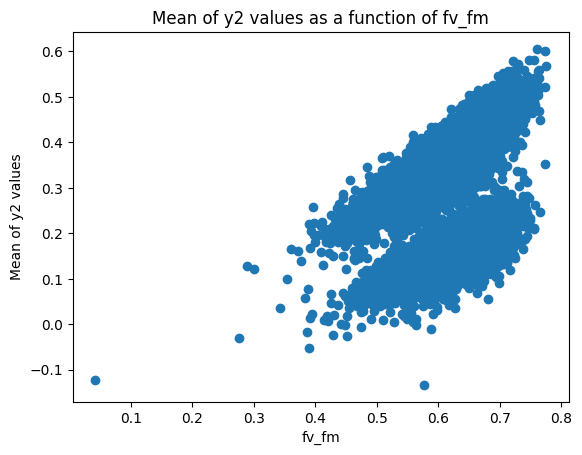

In [4]:
# plot the mean of y2 values as a function of fv_fm
plt.scatter(data['fv_fm'], data['mean_y2'])
plt.xlabel('fv_fm')
plt.ylabel('Mean of y2 values')
plt.title('Mean of y2 values as a function of fv_fm')

#### For each light regime

In [5]:
data = get_format_data_without_na()

In [6]:
data['light_regime'].value_counts()

1min-1min      8186
20h_HL         8172
2h-2h          7453
20h_ML         7399
10min-10min    7098
30s-30s        4647
Name: light_regime, dtype: int64

##### 1min-1min

In [7]:
data_1min = data[data['light_regime'] == '1min-1min']

In [8]:
data_1min['num_frames'].value_counts()

164    8186
Name: num_frames, dtype: int64

Text(0.5, 1.0, 'Mean of 1min Y(II) measurements as a function of fv_fm')

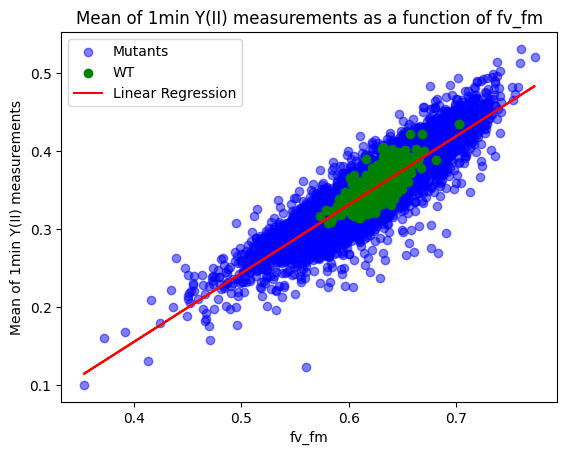

In [9]:
from sklearn.linear_model import LinearRegression

X = data_1min['fv_fm'].values.reshape(-1, 1)
y = data_1min['mean_y2'].values.reshape(-1, 1)

model_1min = LinearRegression()
model_1min.fit(X, y)

y_pred = model_1min.predict(X)

a = data_1min['fv_fm'][data_1min['mutant_ID'] == 'WT'].values.reshape(-1, 1)
b = data_1min['mean_y2'][data_1min['mutant_ID'] == 'WT'].values.reshape(-1, 1)

c = data_1min['fv_fm'][data_1min['mutant_ID'] != 'WT'].values.reshape(-1, 1)
d = data_1min['mean_y2'][data_1min['mutant_ID'] != 'WT'].values.reshape(-1, 1)

plt.scatter(c, d, color='blue', alpha=0.5, label='Mutants')
plt.scatter(a, b, color='green', label='WT')
plt.plot(X, y_pred, color='red', label='Linear Regression')
plt.legend()
plt.xlabel('fv_fm')
plt.ylabel('Mean of 1min Y(II) measurements')
plt.title('Mean of 1min Y(II) measurements as a function of fv_fm')

In [10]:
# The y2_i values where i is odd correspond to dark measurements and the y2_i values where i is even correspond to light measurements
# Let's compute the mean of the dark measurements and the mean of the light measurements for each well

data_1min['mean_dark'] = data_1min.filter(like='y2_')[data_1min.filter(like='y2_').columns[1::2]].mean(axis=1)
data_1min['mean_light'] = data_1min.filter(like='y2_')[data_1min.filter(like='y2_').columns[::2]].mean(axis=1)

/Users/samsongourevitch/Documents/Chlamy_Project/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/samsongourevitch/Documents/Chlamy_Project/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [11]:
data_1min['mean_light']

0        0.214155
1        0.209454
2        0.204015
3        0.189155
4        0.196062
           ...   
42597    0.130527
42598    0.187073
42599    0.088614
42600    0.158333
42601    0.128884
Name: mean_light, Length: 8186, dtype: float64

Text(0.5, 1.0, 'Mean of dark measurements as a function of fv_fm')

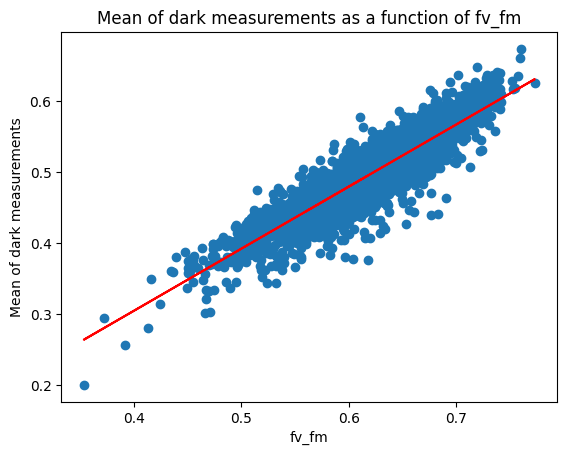

In [12]:
# fit a linear regression model to the data
from sklearn.linear_model import LinearRegression

data_1min = data_1min.dropna(subset=['fv_fm', 'mean_dark'])

X = data_1min['fv_fm'].values.reshape(-1, 1)
y = data_1min['mean_dark'].values.reshape(-1, 1)

model_dark = LinearRegression()
model_dark.fit(X, y)

y_pred = model_dark.predict(X)

plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.xlabel('fv_fm')
plt.ylabel('Mean of dark measurements')
plt.title('Mean of dark measurements as a function of fv_fm')

In [13]:
# print the coefficients of the linear regression model

print('Intercept:', model_dark.intercept_)
print('Slope:', model_dark.coef_[0][0])

Intercept: [-0.04616991]
Slope: 0.87636864


Text(0.5, 1.0, 'Mean of light measurements as a function of fv_fm')

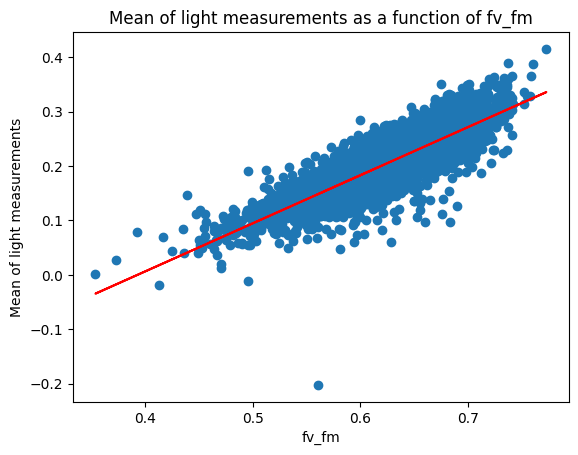

In [14]:
# fit a linear regression model to the data
data_1min = data_1min.dropna(subset=['fv_fm', 'mean_light'])

X = data_1min['fv_fm'].values.reshape(-1, 1)
y = data_1min['mean_light'].values.reshape(-1, 1)

model_light = LinearRegression()
model_light.fit(X, y)

y_pred = model_light.predict(X)

plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.xlabel('fv_fm')
plt.ylabel('Mean of light measurements')
plt.title('Mean of light measurements as a function of fv_fm')

In [15]:
# print the coefficients of the linear regression model

print('Intercept:', model_light.intercept_)
print('Slope:', model_light.coef_[0][0])

Intercept: [-0.34690458]
Slope: 0.88311374


##### Every light regime

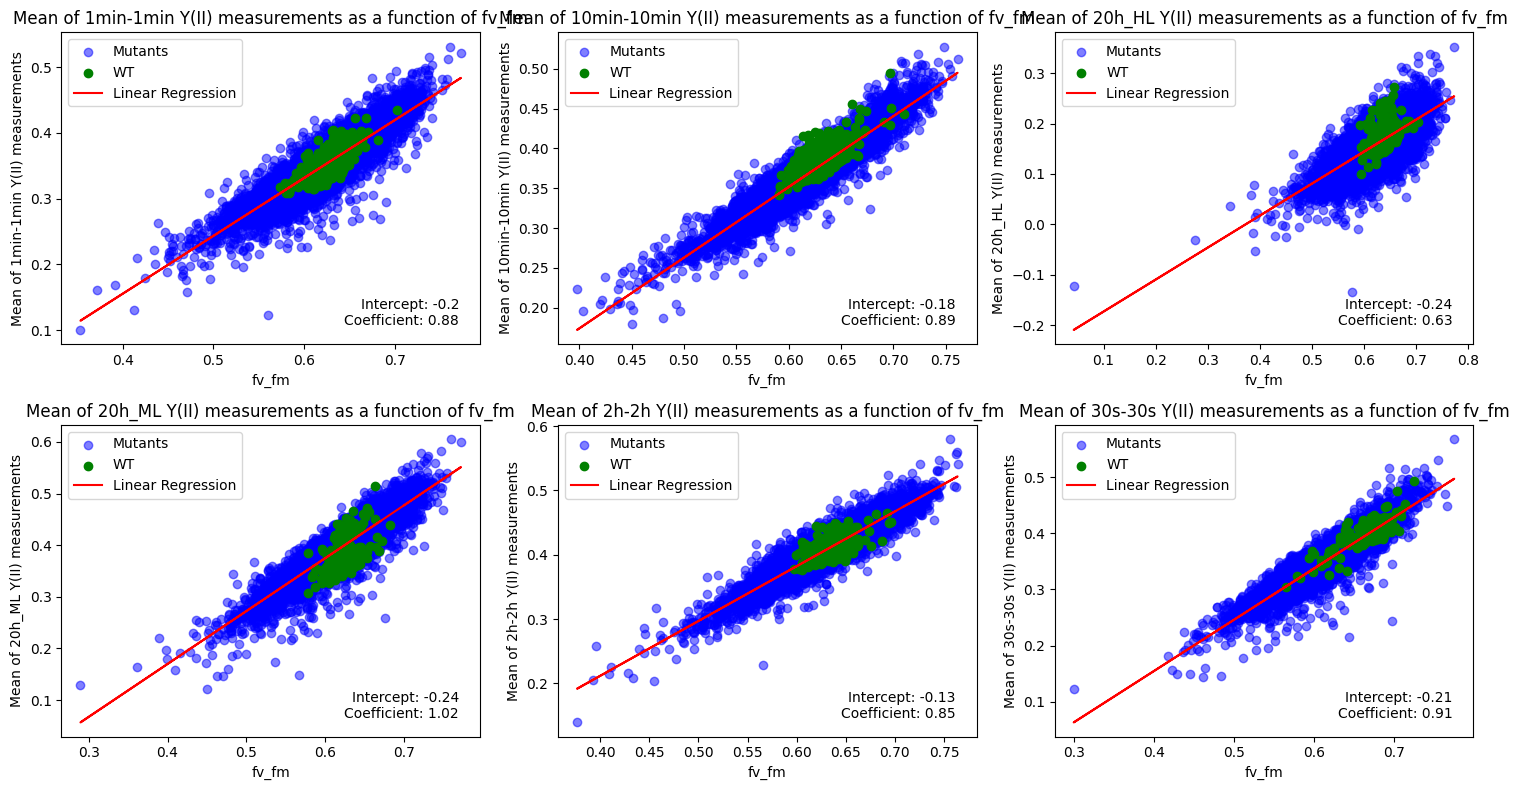

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8)) 

for i, light in enumerate(data['light_regime'].unique()) :
    data_light = data[data['light_regime'] == light]
    a, b = plot_fv_fm_y2_linear_fit(data_light, light, axs[i//3, i%3])

plt.tight_layout()

#### For the WT

##### For the whole dataset

In [18]:
data_WT = data[data['mutant_ID'] == 'WT']

Text(0.5, 1.0, 'Mean of y2 values as a function of fv_fm')

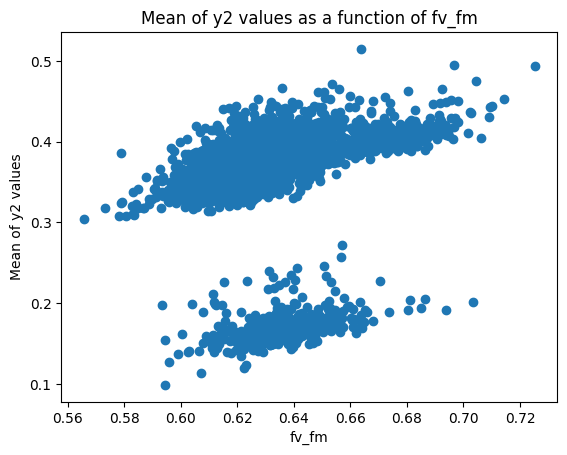

In [19]:
# plot the mean of y2 values as a function of fv_fm
plt.scatter(data_WT['fv_fm'], data_WT['mean_y2'])
plt.xlabel('fv_fm')
plt.ylabel('Mean of y2 values')
plt.title('Mean of y2 values as a function of fv_fm')

##### For each light regime

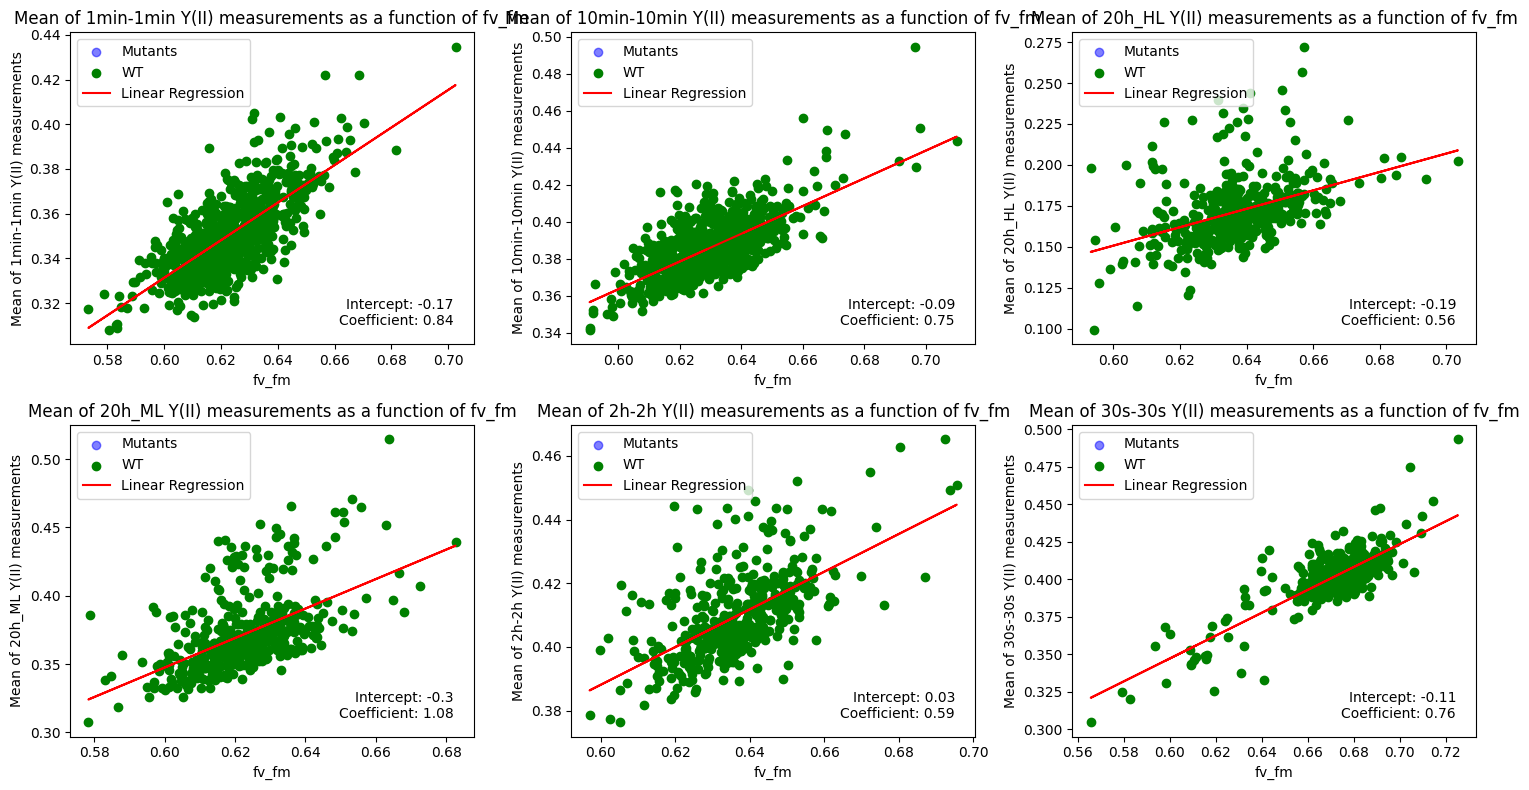

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

for i, light in enumerate(data_WT['light_regime'].unique()) :
    data_light = data_WT[data_WT['light_regime'] == light]
    a, b = plot_fv_fm_y2_linear_fit(data_light, light, axs[i//3, i%3])

plt.tight_layout()

### Normalization of the data

In [21]:
data_norm = normalize_data_additive(data)

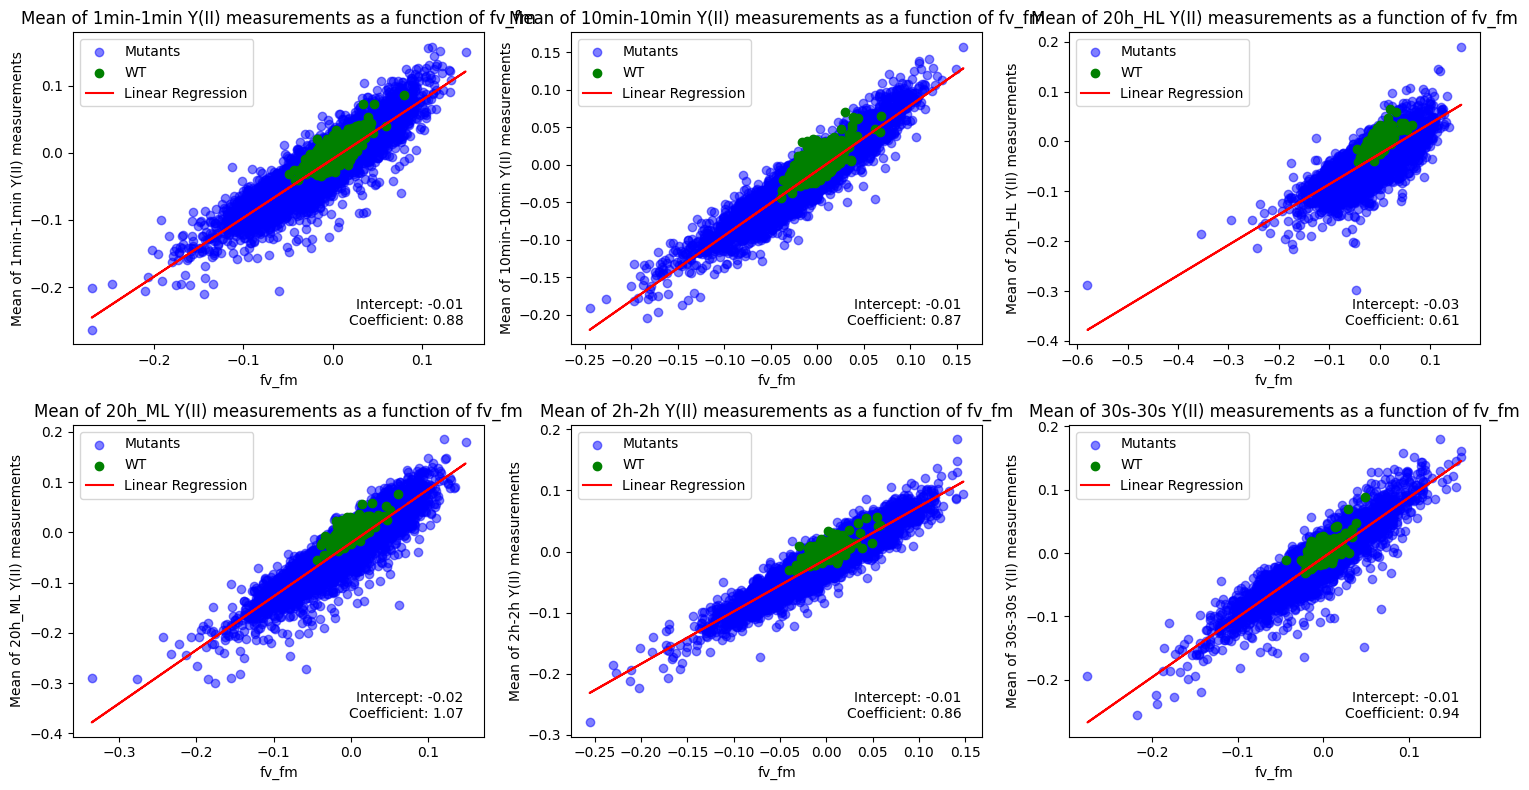

In [22]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8)) 

for i, light in enumerate(data_norm['light_regime'].unique()) :
    data_norm_light = data_norm[data_norm['light_regime'] == light]
    a, b = plot_fv_fm_y2_linear_fit(data_norm_light, light, axs[i//3, i%3])

plt.tight_layout()

In [23]:
data_norm_WT = data_norm[data_norm['mutant_ID'] == 'WT']

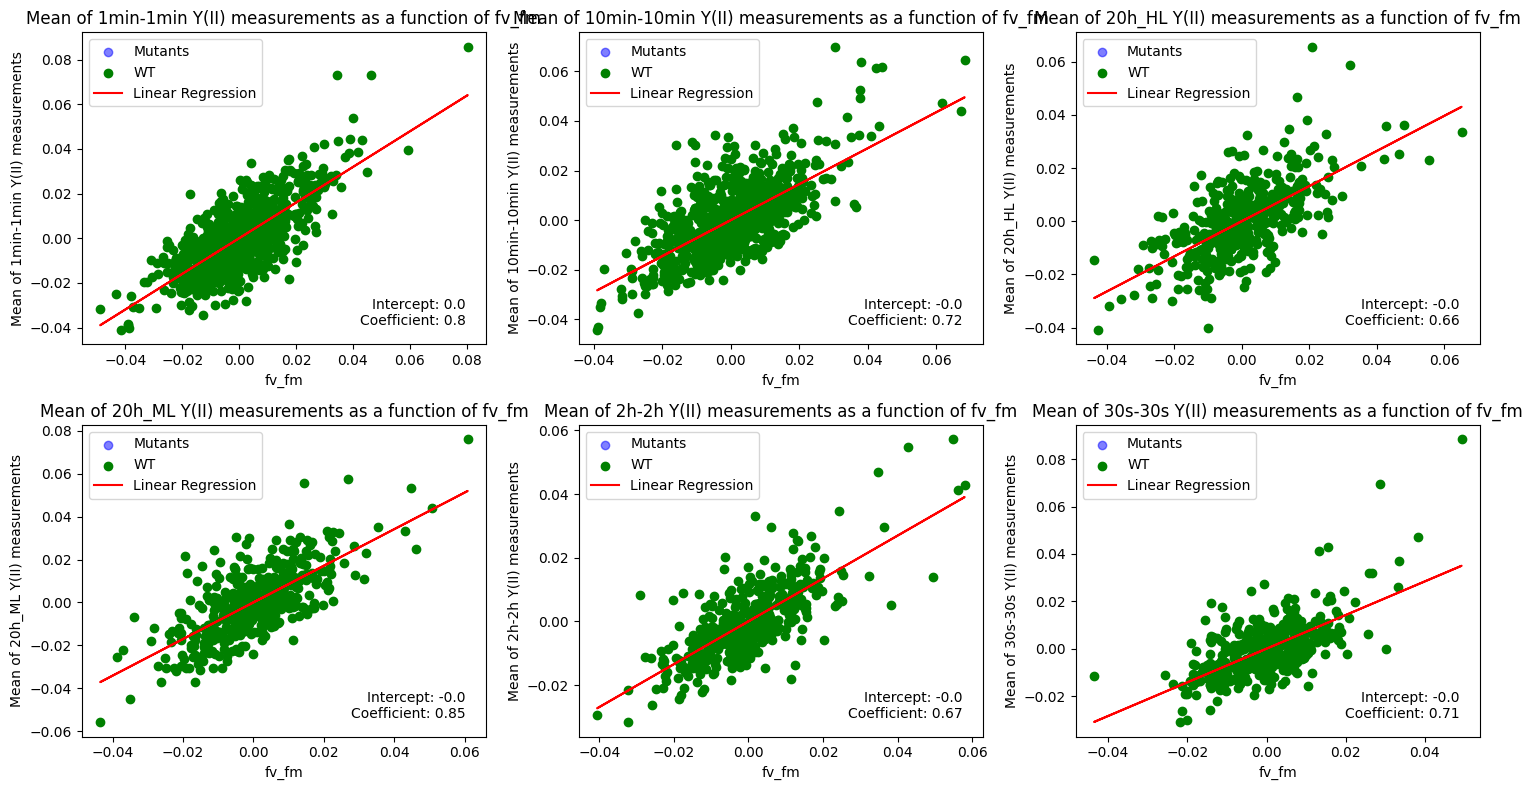

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

for i, light in enumerate(data_norm_WT['light_regime'].unique()) :
    data_light = data_norm_WT[data_norm_WT['light_regime'] == light]
    a, b = plot_fv_fm_y2_linear_fit(data_light, light, axs[i//3, i%3])

plt.tight_layout()